In [1]:
from imports import *
import params
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [3]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = Box(low=0, high=255, shape=self.observation_space.shape[:2], dtype=np.uint8)

    def observation(self, observation):
        transform = transforms.Grayscale()
        return transform(torch.tensor(np.transpose(observation, (2, 0, 1)).copy(), dtype=torch.float))


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        self.shape = (shape, shape)
        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transformations = transforms.Compose([transforms.Resize(self.shape), transforms.Normalize(0, 255)])
        return transformations(observation).squeeze(0)

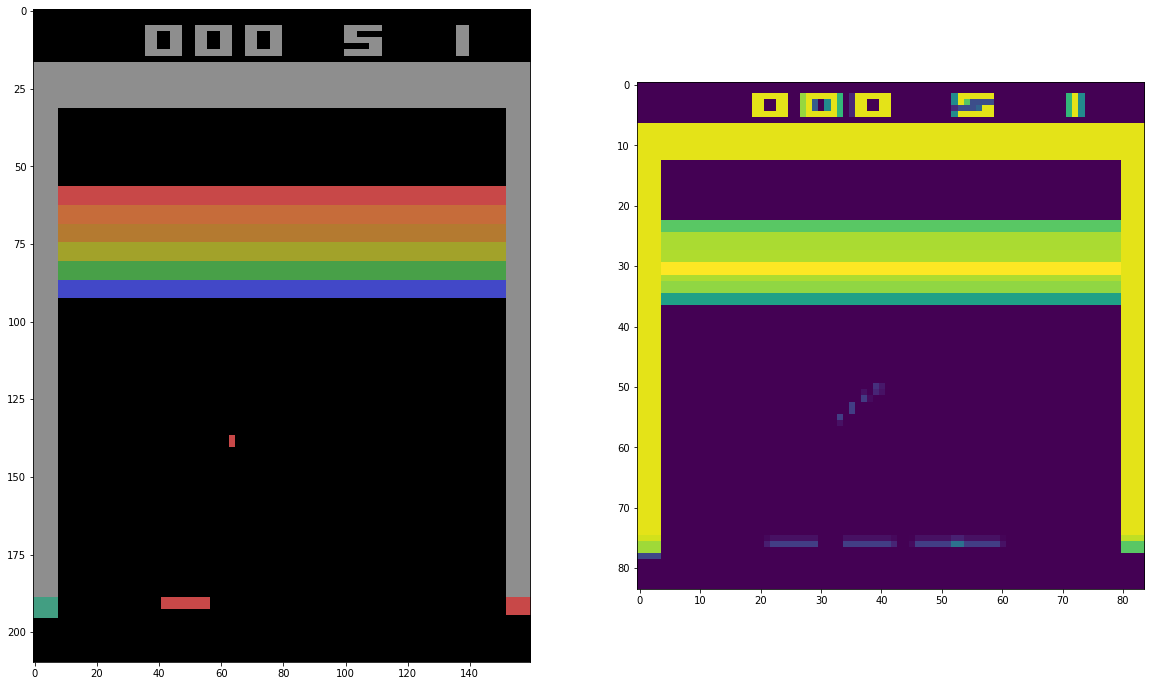

In [4]:
env = gym.make('BreakoutNoFrameskip-v4')

# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)

env.seed(42)
env.action_space.seed(42)
torch.manual_seed(42)
torch.random.manual_seed(42)
random.seed(42)
np.random.seed(42)

env.reset()
env.step(1) #Fire starts the ball rolling; need to do this every life
for i in range(3):
    next_state, reward, done, info = env.step(3)
fr = env.render(mode="rgb_array")
f, ax = plt.subplots(1,2, figsize=(20, 12))
ax[0].imshow(fr)
ax[1].imshow(np.sum(next_state.__array__(),axis=0))

In [5]:
#DQNAgent
import pickle
class DDQNAgent:
    def __init__(self, action_dim, obs_dim, save_directory, rewards_file):
        self.action_dim = action_dim
        self.save_directory = save_directory
        self.net = DDQNSolver(self.action_dim, obs_dim).cuda()
        self.exploration_rate = 1.0
        self.exploration_rate_decay = params.exploration_rate_decay
        self.exploration_rate_min = params.exploration_rate_min
        self.current_step = 0
        self.memory = deque(maxlen=100000) #Not sure why, this version does not keep memory on GPU
        #But 20 GB gets filled with 100k frames
        self.batch_size = 32
        self.gamma = 0.95 #Reward decay
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=1e-4)
        self.loss = torch.nn.SmoothL1Loss()
        self.episode_rewards = []
        self.moving_average_episode_rewards = []
        self.max_average_episode_rewards = []
        self.current_episode_reward = 0.0
        self.burn_in = self.batch_size*10
        self.learn_every = params.learn_every #Every how many collect steps to train
        self.sync_period = 2500*self.learn_every #COPY ONLINE NETWORK TO OFFLINE
        self.rewards_file = rewards_file

        
    def log_episode(self):
        self.episode_rewards.append(self.current_episode_reward)
        self.current_episode_reward = 0.0

    def log_period(self, episode, epsilon, step):
        self.moving_average_episode_rewards.append(np.round(np.mean(self.episode_rewards[-checkpoint_period:]), 3))
        self.max_average_episode_rewards.append(np.round(np.max(self.episode_rewards[-checkpoint_period:]), 3))
        print(f"Episode {episode} | Step {step} | Exploration rate {epsilon:.2f} \
        | Mean Reward {self.moving_average_episode_rewards[-1]} \
        | Max Reward {self.max_average_episode_rewards[-1]}")

        with open(os.path.join(self.save_directory,self.rewards_file), 'w') as f:
            for i, (reward1,reward2) in enumerate(zip(self.moving_average_episode_rewards,self.max_average_episode_rewards)):
                f.write("%d %.1f %.1f\n" %(i,reward1,reward2))


    def remember(self, state, next_state, action, reward, done):
        self.memory.append((torch.tensor(state.__array__()), torch.tensor(next_state.__array__()),
                            torch.tensor([action]), torch.tensor([reward]), torch.tensor([done])))

        
    def experience_replay(self, step_reward):
        self.current_episode_reward += step_reward
        
        if self.current_step%self.sync_period == 0: #Copy network pieces if time
            self.net.target_conv.load_state_dict(self.net.conv.state_dict())
            self.net.target_linear_adv.load_state_dict(self.net.linear_adv.state_dict())
            self.net.target_linear_val.load_state_dict(self.net.linear_val.state_dict())
            
        if len(self.memory)<self.burn_in: #Don't train till have collected enough data
            if(self.current_step%100==0): 
                print("Collecting data without training on step %d" %self.current_step)
            return

        if self.current_step%self.learn_every !=0 : #Learn every N steps
            return
        
        state, next_state, action, reward, done = self.recall()
        q_estimate = self.net(state.cuda(), model="online")[np.arange(0, self.batch_size), action.cuda()]
        with torch.no_grad():
            action_preds = self.net(next_state.cuda(), model="online")
            best_action = torch.argmax(action_preds, dim=1)
            
            next_q = self.net(next_state.cuda(), model="target")[np.arange(0, self.batch_size), best_action]
            q_target = (reward.cuda() + (1 - done.cuda().float()) * self.gamma * next_q).float()
        loss = self.loss(q_estimate, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        
    def recall(self):
        state, next_state, action, reward, done = map(torch.stack, zip(*random.sample(self.memory, self.batch_size)))
        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

    def act(self, state):
        if np.random.rand() < self.exploration_rate:
            action = np.random.randint(self.action_dim)
        else:
            action_values = self.net(torch.tensor(state.__array__()).cuda().unsqueeze(0), model="online")
            action = torch.argmax(action_values, dim=1).item()
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)
        self.current_step += 1
        return action

    
    def load_checkpoint(self, path):
        checkpoint = torch.load(path)
        self.net.load_state_dict(checkpoint['model'])
        self.exploration_rate = checkpoint['exploration_rate']

        
    def save_checkpoint(self):
        filename = os.path.join(self.save_directory, 'checkpoint_{}.pth'.format(episode))
        torch.save(dict(model=self.net.state_dict(), exploration_rate=self.exploration_rate), f=filename)
        print('Checkpoint saved to \'{}\''.format(filename))
        
        #Save experience replay for checkpointing
        if params.save_memory: 
            filename = os.path.join(self.save_directory, 'memory_{}.pkl'.format(episode))
            p_file = open(filename, 'wb')
            pickle.dump(self.memory, p_file)
            p_file.close()


In [6]:
#Summary of model    
from torchsummary import summary
from DDQNSolver import DDQNSolver
model = DDQNSolver(env.action_space.n, env.observation_space.shape)
print(summary(model,(4,84,84),device="cpu"))

Flattened layer size is 6400
Flattened layer size is 6400
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 84, 84]           1,184
              ReLU-2           [-1, 32, 84, 84]               0
         MaxPool2d-3           [-1, 32, 42, 42]               0
            Conv2d-4           [-1, 64, 42, 42]          18,496
              ReLU-5           [-1, 64, 42, 42]               0
         MaxPool2d-6           [-1, 64, 21, 21]               0
            Conv2d-7           [-1, 64, 21, 21]          36,928
              ReLU-8           [-1, 64, 21, 21]               0
         MaxPool2d-9           [-1, 64, 10, 10]               0
          Flatten-10                 [-1, 6400]               0
           Linear-11                  [-1, 512]       3,277,312
             ReLU-12                  [-1, 512]               0
           Linear-13                    [-1, 

In [7]:
#Load checkpoint
checkpoint_period = params.checkpoint_period
episode = params.episode
max_episodes = params.max_episodes    


#Log rewards and network weights
rewards_file = params.rewards_file
save_directory = params.save_directory
if not os.path.exists (os.getcwd() + '/' + save_directory):
    os.mkdir(os.getcwd() + '/' + save_directory)

In [8]:
#Initialize agent
agent = DDQNAgent(action_dim=env.action_space.n, obs_dim = env.observation_space.shape,
                  save_directory=save_directory, rewards_file=rewards_file)

if params.load_checkpoint is not None: #Start from checkpoint?
    agent.load_checkpoint(save_directory + "/" + params.load_checkpoint) #Load weights
    memory_file = save_directory + "/memory_%d.pkl" %episode #Load experience replay deque
    agent.memory = pickle.load( open( memory_file, "rb" ) )
    agent.current_step = episode * env.Nvacs #Load number of steps

Flattened layer size is 6400
Flattened layer size is 6400


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
#Training loop
use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")
print()

while episode<max_episodes:
    state = env.reset()
    cstep = 0 #Keep track of steps in this episode
    while True:
        action = agent.act(state)
        if cstep==0: 
            action = np.random.randint(agent.action_dim) 
            #Take first action randomly so start from different places
        cstep+=1
        next_state, reward, done, info = env.step(action)
        agent.remember(state, next_state, action, reward, done)
        agent.experience_replay(reward)
        state = next_state
        if done:
            cstep = 0
            episode += 1
            agent.log_episode()
            if episode % checkpoint_period == 0:
                agent.log_period(episode=episode, epsilon=agent.exploration_rate, step=agent.current_step)
                agent.save_checkpoint()
                plt.imshow(state.__array__().squeeze().T, origin='lower')
                plt.savefig(save_directory + "/img%d.png" %episode)
                plt.close()
            break

Using CUDA: True

Episode 100 | Step 18295 | Exploration rate 0.91         | Mean Reward 1.26         | Max Reward 4.0
Checkpoint saved to 'v2/checkpoint_100.pth'
Episode 200 | Step 36365 | Exploration rate 0.83         | Mean Reward 1.22         | Max Reward 10.0
Checkpoint saved to 'v2/checkpoint_200.pth'
Episode 300 | Step 56132 | Exploration rate 0.76         | Mean Reward 1.6         | Max Reward 8.0
Checkpoint saved to 'v2/checkpoint_300.pth'
Episode 400 | Step 74782 | Exploration rate 0.69         | Mean Reward 1.33         | Max Reward 7.0
Checkpoint saved to 'v2/checkpoint_400.pth'
Episode 500 | Step 92807 | Exploration rate 0.63         | Mean Reward 1.09         | Max Reward 5.0
Checkpoint saved to 'v2/checkpoint_500.pth'
Episode 600 | Step 112152 | Exploration rate 0.57         | Mean Reward 1.46         | Max Reward 6.0
Checkpoint saved to 'v2/checkpoint_600.pth'
Episode 700 | Step 133111 | Exploration rate 0.51         | Mean Reward 2.2         | Max Reward 8.0
Checkpoint